# IFT6135-A2022
# Assignment 2: Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `solution.py` and submit it on Gradescope.

Only edit the functions specified in the PDF (and wherever marked – `# WRITE CODE HERE`). Do not change definitions or edit the rest of the template, else the autograder will not work.

**Make sure you request a GPU runtime!**

In [ ]:
# DO NOT MODIFY!
import math
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

device = "cuda" if torch.cuda.is_available() else "cpu"

def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_experiment_seed()

#### Data pre-processing

Run the cells below by clicking the Run/Play button, but do not modify the code.

In [ ]:
from collections import Counter
import io
import os
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive

In [ ]:
os.system("python3 -m spacy download en_core_web_sm")
os.system("python3 -m spacy download fr_core_news_sm")

0

In [ ]:
en_tokenizer = torchtext.data.utils.get_tokenizer("spacy", "en_core_web_sm")
fr_tokenizer = torchtext.data.utils.get_tokenizer("spacy", "fr_core_news_sm")

In [ ]:
base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
train_urls = ["train.en.gz", "train.fr.gz"]
val_urls = ["val.en.gz", "val.fr.gz"]
test_urls = ["test_2016_flickr.en.gz", "test_2016_flickr.fr.gz"]
train_paths = [extract_archive(download_from_url(base_url + url))[0] for url in train_urls]
val_paths = [extract_archive(download_from_url(base_url + url))[0] for url in val_urls]
test_paths = [extract_archive(download_from_url(base_url + url))[0] for url in test_urls]

100%|██████████| 569k/569k [00:00<00:00, 13.4MB/s]
100%|██████████| 604k/604k [00:00<00:00, 13.1MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 6.74MB/s]
100%|██████████| 23.0k/23.0k [00:00<00:00, 3.35MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 4.31MB/s]
100%|██████████| 22.3k/22.3k [00:00<00:00, 6.25MB/s]


In [ ]:
def generate_vocabulary(path, tokenizer):
    counter = Counter()
    with io.open(path, encoding="utf8") as f:
        for item in f:
            counter.update(tokenizer(item))
    vocabulary = torchtext.vocab.vocab(counter, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
    vocabulary.set_default_index(vocabulary["<unk>"])
    return vocabulary

en_vocabulary = generate_vocabulary(train_paths[0], en_tokenizer)
fr_vocabulary = generate_vocabulary(train_paths[1], fr_tokenizer)

In [ ]:
def get_processed_data(paths):
    en_file_io = iter(io.open(paths[0], encoding="utf8"))
    fr_file_io = iter(io.open(paths[1], encoding="utf8"))
    data = []
    for en_item, fr_item in zip(en_file_io, fr_file_io):
        en_processed = torch.tensor([en_vocabulary[token] for token in en_tokenizer(en_item)], dtype=torch.long)
        fr_processed = torch.tensor([fr_vocabulary[token] for token in fr_tokenizer(fr_item)], dtype=torch.long)
        data.append((en_processed, fr_processed))
    return data

train_data = get_processed_data(train_paths)
val_data = get_processed_data(val_paths)
test_data = get_processed_data(test_paths)

### GRU Encoder-Decoder Model for Machine Translation

#### Dataloader

Running this cell will create `train_loader`, `val_loader` and `test_loader` for training, validation and testing respectively. The batch size is 128 and all sequences are of length 60 – shorter sequences are padded to this length. For this question, the data is provided in the shape `[sequence_length, batch_size]`. You need not modify this.

In [ ]:
special_idx = {
    "bos": en_vocabulary["<bos>"],
    "pad": en_vocabulary["<pad>"],
    "eos": en_vocabulary["<eos>"]
}

max_len = 60

def get_batch(data):
    en_batch_, fr_batch_ = [], []
    for en_item, fr_item in data:
        en_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), en_item, torch.tensor([special_idx["eos"]])], dim=0))
        fr_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), fr_item, torch.tensor([special_idx["eos"]])], dim=0))
    en_batch_ = nn.utils.rnn.pad_sequence(en_batch_, padding_value=special_idx["pad"])
    fr_batch_ = nn.utils.rnn.pad_sequence(fr_batch_, padding_value=special_idx["pad"])
    en_batch = torch.full((max_len, en_batch_.shape[1]), special_idx["pad"])
    en_batch[:en_batch_.shape[0], :] = en_batch_
    fr_batch = torch.full((max_len, fr_batch_.shape[1]), special_idx["pad"])
    fr_batch[:fr_batch_.shape[0], :] = fr_batch_
    return en_batch, fr_batch

batch_size = 128
if __name__ == "__main__":
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)

In [ ]:
!nvidia-smi

Sun Nov 13 23:22:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |    840MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Encoder-Decoder Model

In [ ]:
class Encoder(nn.Module):
    """
    Defines an encoder model containing a GRU.
    """
    def __init__(
        self,
        vocabulary_size=10838, # Size of source vocabulary, given by len(en_vocabulary)
        embedding_size=32,     # Size of nn.Embedding
        hidden_size=64,        # Hidden size for nn.GRU
        num_layers=1,          # Number of layers in the nn.GRU
        use_dropout=False,     # Whether or not to use Dropout
        p_dropout=0.1          # Dropout probability
    ):
        super(Encoder, self).__init__()

        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_dropout = use_dropout

        self.embedding   = nn.Embedding(self.vocabulary_size,self.embedding_size,padding_idx =special_idx["pad"] ) #  (for padding_idx, use special_idx["pad"])
        if self.use_dropout:
            self.dropout = nn.Dropout(p_dropout)
        self.gru         = nn.GRU(self.embedding_size,self.hidden_size,self.num_layers)

    def forward(self, x):
        out = self.embedding(x)
        if self.use_dropout:
          out = self.dropout(out)
        out,f_hidden = self.gru(out)
        # x -> embedding -> dropout (if use_dropout) -> gru -> return output and final hidden
        return out,f_hidden

In [ ]:
# from tqdm import tqdm
# data_source, data_target = [],[]
# for source, target in tqdm(train_loader):
#     data_source.append(source)
#     data_target.append(target)

In [ ]:
# source = data_source[0]
# target = data_target[0]

In [ ]:
# _,hidden = Encoder()(source)
# out = (Decoder()(target[0],hidden)[0])
# out.shape

In [ ]:
# Encoder().embedding(out)

In [ ]:
# # out = torch.argmax(out,1)
# out

In [ ]:
# hidden.shape

In [ ]:
class Decoder(nn.Module):
    """
    Defines a decoder model containing a GRU.
    """
    def __init__(
        self,
        vocabulary_size=11510, # Size of target vocabulary, given by len(fr_vocabulary)
        embedding_size=32,     # Size of nn.Embedding
        hidden_size=64,        # Hidden size for nn.GRU
        num_layers=1,          # Number of layers in the nn.GRU
        use_dropout=False,     # Whether or not to use Dropout
        p_dropout=0.1          # Dropout probability
    ):
        super(Decoder, self).__init__()

        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_dropout = use_dropout

        self.embedding   = nn.Embedding(self.vocabulary_size,self.embedding_size )
        if self.use_dropout:
            self.dropout = nn.Dropout(p_dropout) # WRITE CODE HERE (use p_dropout)
        self.gru         = nn.GRU(self.embedding_size,self.hidden_size,self.num_layers,batch_first=False) # WRITE CODE HERE (set batch_first=False)
        self.fc          = nn.Linear(self.hidden_size,self.vocabulary_size)

    def forward(self, x, hidden):
        x = x.unsqueeze(0)
        out = self.embedding(x)
        if self.use_dropout:
          out = self.dropout(out)
        output,f_hidden = self.gru(out,hidden)
        output = output.squeeze(0)
        out = (self.fc(output))
        # x -> embedding -> dropout (if use_dropout) -> gru -> output and final hidden
        # output -> fc -> out
        # return out and final hidden


        return out,f_hidden

In [ ]:
class Seq2Seq(nn.Module):
    """
    Defines an encoder-decoder (sequence-to-sequence) model for machine translation.
    """
    def __init__(
        self,
        encoder,
        decoder,
        strategy="greedy"
    ):
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.strategy = strategy

    def forward(self, source, target):
        batch_size = source.shape[1]
        max_length = target.shape[0]
        target_vocabulary_size = self.decoder.vocabulary_size

        outputs = torch.zeros(max_length, batch_size, target_vocabulary_size).to(device)
        sentences = torch.zeros(max_length, batch_size).to(device)

        # Get the encoder outputs and hidden state for the source sentences
        encoder_out, hidden = self.encoder(source)

        # The first input token passed to the decoder is <bos>
        out = target[0, :]

        if self.strategy == "greedy":
            for idx in range(1, max_length):
                # WRITE CODE HERE

                # Get the decoder outputs and hidden state for the input token and hidden state
                out, hidden = self.decoder(out,hidden)
                outputs[idx] = out


                # WRITE CODE HERE
                # Reassign out with the greedy choice (argmax) for each batch
                # (batch_size, vocabulary_size) -> (batch_size)
                out = torch.argmax(out,1)

                sentences[idx] = out

        elif self.strategy == "random":
            temperature = 0.5
            for idx in range(1, max_length):
                # WRITE CODE HERE
                # Get the decoder outputs and hidden state for the input token and hidden state
                out, hidden = self.decoder(out,hidden)

                outputs[idx] = out

                # WRITE CODE HERE
                # Reassign out with the randomly sampled choice for each batch
                #  p(x_i | x_{1:i-1}) =  exp(o_i / temperature) / sum(exp(o / temperature))
                # (batch_size, vocabulary_size) -> (batch_size)
                temperature = 0.5
                P = nn.functional.softmax(out/temperature, dim=1)
                out = torch.multinomial(P,1).squeeze(-1)

                sentences[idx] = out
        else:
            raise Exception("Invalid decoding strategy!")

        return outputs, sentences

In [ ]:
# _,hidden = Encoder()(source)
# out = target[2, :]
#
# out,hidden = Decoder()(out,hidden)
# temperature = 0.5
# P = nn.functional.softmax(out/temperature)
# P.shape


In [ ]:
# torch.multinomial(P,1).squeeze(-1)

In [ ]:
# a = torch.distributions.categorical.Categorical(torch.Tensor([.1,.1,.8])).sample(
# )
# d = []
# for j in range(100):
#   d.append(torch.distributions.categorical.Categorical(torch.Tensor([.15,.1,.8])).sample(
# ))

In [ ]:

# nn.functional.softmax(out/temperature) == torch.stack([torch.exp(out[i] / temperature) / sum(torch.exp(out / temperature)) for i in range(len(out))])
# # P0 = torch.distributions.categorical.Categorical(P)
# (out/temperature)[0][5] == out[0][5]/temperature

In [ ]:
# sum(P[2])
# sum(nn.functional.softmax(out[0]/temperature))

#### Training

In [ ]:
def get_criterion():
    # WRITE CODE HERE
    # The criterion must compute the cross-entropy loss but ignore special_idx["pad"].
    criterion = nn.CrossEntropyLoss(ignore_index=special_idx["pad"])
    return criterion

In [ ]:
def train(model, dataloader, optimizer, criterion):
    train_loss = 0.
    train_ppl = 0.
    model.train()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output, _ = model(source, target)
        output_reshape = output[1:].view(-1, output.shape[-1])
        target = target[1:].view(-1)
        loss = criterion(output_reshape, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_ppl = math.exp(train_loss)
    train_time = end - start
    return train_loss, train_ppl, train_time

def validate(model, dataloader, criterion):
    val_loss = 0.
    val_ppl = 0.
    model.eval()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output, _ = model(source, target)
        output_reshape = output[1:].view(-1, output.shape[-1])
        target = target[1:].view(-1)
        loss = criterion(output_reshape, target)
        val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_ppl = math.exp(val_loss)
    val_time = end - start
    return val_loss, val_ppl, val_time

def compute_bleu_gru(model, dataloader):
    targets = []
    translations = []

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        _, output = model(source, target)
        for i in range(target.shape[1]):
            targets.append([[]])
            for token in target[1:, i]:
                if token in special_idx.values():
                    break
                targets[-1][0].append(fr_vocabulary.get_itos()[token])
            translations.append([])
            for token in output[1:, i]:
                if token in special_idx.values():
                    break
                translations[-1].append(fr_vocabulary.get_itos()[token.int().item()])

    return torchtext.data.metrics.bleu_score(translations, targets, max_n=1, weights=[1]) * 100, \
           torchtext.data.metrics.bleu_score(translations, targets, max_n=2, weights=[0.5]*2) * 100,

In [ ]:
fix_experiment_seed()
use_dropout = False
strategy = "greedy"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.Adam(model.parameters())
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 6.023 | Train PPL: 412.884 | Train Time: 89.801
Valid Loss: 5.125 | Valid PPL: 168.192 | Valid Time: 1.386
Epoch: 1
Train Loss: 5.062 | Train PPL: 157.861 | Train Time: 88.168
Valid Loss: 5.046 | Valid PPL: 155.342 | Valid Time: 1.400
Epoch: 2
Train Loss: 5.008 | Train PPL: 149.572 | Train Time: 88.036
Valid Loss: 5.023 | Valid PPL: 151.890 | Valid Time: 1.390
Epoch: 3
Train Loss: 4.985 | Train PPL: 146.167 | Train Time: 88.115
Valid Loss: 5.021 | Valid PPL: 151.536 | Valid Time: 1.387
Epoch: 4
Train Loss: 4.971 | Train PPL: 144.183 | Train Time: 88.024
Valid Loss: 5.017 | Valid PPL: 151.017 | Valid Time: 1.381
Epoch: 5
Train Loss: 4.963 | Train PPL: 142.954 | Train Time: 88.147
Valid Loss: 5.018 | Valid PPL: 151.169 | Valid Time: 1.393
Epoch: 6
Train Loss: 4.956 | Train PPL: 141.977 | Train Time: 88.028
Valid Loss: 5.019 | Valid PPL: 151.247 | Valid Time: 1.371
Epoch: 7
Train Loss: 4.950 | Train PPL: 141.228 | Train Time: 88.028
Valid Loss: 5.019 | Valid PPL: 151.

In [ ]:
!nvidia-smi

Sun Nov 13 23:39:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   3312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-sgd-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 9.308 | Train PPL: 11029.010 | Train Time: 89.723
Valid Loss: 9.248 | Valid PPL: 10383.806 | Valid Time: 1.397
Epoch: 1
Train Loss: 9.132 | Train PPL: 9245.380 | Train Time: 88.327
Valid Loss: 8.715 | Valid PPL: 6090.888 | Valid Time: 1.423
Epoch: 2
Train Loss: 8.122 | Train PPL: 3366.543 | Train Time: 88.470
Valid Loss: 7.611 | Valid PPL: 2019.696 | Valid Time: 1.429
Epoch: 3
Train Loss: 7.565 | Train PPL: 1929.451 | Train Time: 88.600
Valid Loss: 7.388 | Valid PPL: 1616.506 | Valid Time: 1.394
Epoch: 4
Train Loss: 7.175 | Train PPL: 1306.021 | Train Time: 88.426
Valid Loss: 7.023 | Valid PPL: 1122.478 | Valid Time: 1.401
Epoch: 5
Train Loss: 6.901 | Train PPL: 993.585 | Train Time: 88.301
Valid Loss: 6.798 | Valid PPL: 895.692 | Valid Time: 1.388
Epoch: 6
Train Loss: 6.712 | Train PPL: 822.402 | Train Time: 88.959
Valid Loss: 6.632 | Valid PPL: 759.335 | Valid Time: 1.389
Epoch: 7
Train Loss: 6.580 | Train PPL: 720.492 | Train Time: 88.524
Valid Loss: 6.523 | Val

In [ ]:
!nvidia-smi

Sun Nov 13 23:58:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   3312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.Adam(model.parameters())
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 5.889 | Train PPL: 361.086 | Train Time: 88.945
Valid Loss: 5.103 | Valid PPL: 164.547 | Valid Time: 1.413
Epoch: 1
Train Loss: 5.048 | Train PPL: 155.746 | Train Time: 88.803
Valid Loss: 5.039 | Valid PPL: 154.278 | Valid Time: 1.409
Epoch: 2
Train Loss: 5.001 | Train PPL: 148.632 | Train Time: 88.599
Valid Loss: 5.022 | Valid PPL: 151.766 | Valid Time: 1.382
Epoch: 3
Train Loss: 4.982 | Train PPL: 145.770 | Train Time: 88.590
Valid Loss: 5.021 | Valid PPL: 151.617 | Valid Time: 1.380
Epoch: 4
Train Loss: 4.970 | Train PPL: 144.010 | Train Time: 88.576
Valid Loss: 5.019 | Valid PPL: 151.295 | Valid Time: 1.456
Epoch: 5
Train Loss: 4.962 | Train PPL: 142.881 | Train Time: 88.687
Valid Loss: 5.021 | Valid PPL: 151.575 | Valid Time: 1.455
Epoch: 6
Train Loss: 4.955 | Train PPL: 141.951 | Train Time: 88.452
Valid Loss: 5.021 | Valid PPL: 151.544 | Valid Time: 1.390
Epoch: 7
Train Loss: 4.950 | Train PPL: 141.221 | Train Time: 88.772
Valid Loss: 5.021 | Valid PPL: 151.

In [ ]:
!nvidia-smi

Mon Nov 14 00:13:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   3314MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "random"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.Adam(model.parameters())
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 5.937 | Train PPL: 378.653 | Train Time: 94.040
Valid Loss: 5.160 | Valid PPL: 174.095 | Valid Time: 1.568
Epoch: 1
Train Loss: 5.080 | Train PPL: 160.729 | Train Time: 93.728
Valid Loss: 5.059 | Valid PPL: 157.414 | Valid Time: 1.589
Epoch: 2
Train Loss: 5.023 | Train PPL: 151.885 | Train Time: 93.818
Valid Loss: 5.037 | Valid PPL: 154.014 | Valid Time: 1.571
Epoch: 3
Train Loss: 5.001 | Train PPL: 148.547 | Train Time: 93.742
Valid Loss: 5.034 | Valid PPL: 153.554 | Valid Time: 1.569
Epoch: 4
Train Loss: 4.987 | Train PPL: 146.454 | Train Time: 93.796
Valid Loss: 5.028 | Valid PPL: 152.635 | Valid Time: 1.559
Epoch: 5
Train Loss: 4.916 | Train PPL: 136.403 | Train Time: 93.748
Valid Loss: 4.847 | Valid PPL: 127.356 | Valid Time: 1.587
Epoch: 6
Train Loss: 4.734 | Train PPL: 113.735 | Train Time: 93.642
Valid Loss: 4.762 | Valid PPL: 116.965 | Valid Time: 1.569
Epoch: 7
Train Loss: 4.640 | Train PPL: 103.579 | Train Time: 93.669
Valid Loss: 4.663 | Valid PPL: 105.

In [ ]:
!nvidia-smi

Mon Nov 14 00:30:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   3314MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Basic Tests

In [ ]:
class TestSeq2SeqShapes():
    def __init__(self):
        self.vocabulary_size = 11
        self.embedding_size = 13
        self.hidden_size = 17
        self.num_layers = 1

        self.encoder = Encoder(
            vocabulary_size=self.vocabulary_size,
            embedding_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            use_dropout=False,
            p_dropout=0.1
        )
        self.decoder = Decoder(
            vocabulary_size=self.vocabulary_size,
            embedding_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            use_dropout=False,
            p_dropout=0.1
        )
        self.model = Seq2Seq(
            self.encoder, self.decoder, strategy="greedy"
        )

    def test_forward_shape(self):
        batch_size = 5
        sequence_length = 7
        tokens = torch.randint(self.vocabulary_size, size=(sequence_length, batch_size))

        outputs = self.encoder(tokens)

        assert isinstance(outputs, (tuple, list)), (
            "The output of the module must be encoder_outputs, hidden_state."
        )
        assert len(outputs) == 2, (
            "The output of the module must be encoder_outputs, hidden_state."
        )

        out, h = outputs

        expected_shape = (1, batch_size, self.hidden_size)
        assert isinstance(h, torch.Tensor), (
            "The hidden_state must be a torch.Tensor."
        )
        assert h.shape == expected_shape, (
            "The shape of `hidden_state` is invalid. Got shape {0}"
            "\n  Expected shape: {1}\n Recall that the final hidden_state should have shape "
            "(1, batch_size, hidden_size)".format(
                tuple(h.shape), expected_shape
            )
        )

        outputs = self.decoder(tokens[0, :], h)

        expected_shape = (batch_size, self.vocabulary_size)
        assert isinstance(outputs, (tuple, list)), (
            "The output of the module must ba a tuple scores, hidden_state."
        )
        assert len(outputs) == 2, (
            "The output of the module must ba a tuple scores, hidden_state."
        )

        out, h = outputs

        assert out.shape == expected_shape, (
            "The shape of decoder output is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that the output should have shape "
            "(batch_size, vocabulary_size)".format(
                tuple(out.shape), expected_shape
            )
        )
        assert h.shape == (1, batch_size, self.hidden_size), (
            "The shape of final hidden state is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that the output should have shape "
            "(1, batch_size, hidden_size)".format(
                tuple(h.shape), (1, batch_size, self.hidden_size)
            )
        )

        o, s = self.model(tokens, tokens)

        assert o.shape == (sequence_length, batch_size, self.vocabulary_size), (
            "The shape of Seq2Seq output is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that the output should have shape "
            "(sequence_length, batch_size, vocabulary_size)".format(
                tuple(o.shape), (sequence_length, batch_size, self.vocabulary_size)
            )
        )

        assert s.shape == (sequence_length, batch_size), (
            "The shape of Seq2Seq sentences is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that this should have shape "
            "(sequence_length, batch_size)".format(
                tuple(s.shape), (sequence_length, batch_size)
            )
        )

if __name__ == "__main__":
    TestSeq2SeqShapes().test_forward_shape()

### Transformer Encoder-Decoder Model for Machine Translation

#### Dataloader

Running this cell will create `train_loader`, `val_loader` and `test_loader` for training, validation and testing respectively. The batch size is 128 and all sequences are of length 60 – shorter sequences are padded to this length. For this question, the data is provided in the shape `[batch_size, sequence_length]`. You need not modify this.

In [ ]:
special_idx = {
    "bos": en_vocabulary["<bos>"],
    "pad": en_vocabulary["<pad>"],
    "eos": en_vocabulary["<eos>"]
}

max_len = 60

def get_batch(data):
    en_batch_, fr_batch_ = [], []
    for en_item, fr_item in data:
        en_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), en_item, torch.tensor([special_idx["eos"]])], dim=0))
        fr_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), fr_item, torch.tensor([special_idx["eos"]])], dim=0))
    en_batch_ = nn.utils.rnn.pad_sequence(en_batch_, padding_value=special_idx["pad"], batch_first=True)
    fr_batch_ = nn.utils.rnn.pad_sequence(fr_batch_, padding_value=special_idx["pad"], batch_first=True)
    en_batch = torch.full((en_batch_.shape[0], max_len), special_idx["pad"])
    en_batch[:, :en_batch_.shape[1]] = en_batch_
    fr_batch = torch.full((fr_batch_.shape[0], max_len), special_idx["pad"])
    fr_batch[:, :fr_batch_.shape[1]] = fr_batch_
    return en_batch, fr_batch

batch_size = 128
if __name__ == "__main__":
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)

#### Embeddings

The classes below are used to get the Transformer embeddings. The embeddings are made up of positional encodings and token embeddings. You do not need to modify the code, and you may run it by just clicking the run/play button.

In [ ]:
class PostionalEncoding(nn.Module):
    """
    Provides positional information for tokens, which is to be added with the token embeddings.
    """
    def __init__(self, d_model, max_len=max_len, device=device):
        super(PostionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        _2i = torch.arange(0, d_model, step=2, device=device).float()

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        batch_size, seq_len = x.size()
        return self.encoding[:seq_len, :]

class TransformerEmbedding(nn.Module):
    """
    Gives embeddings made up of token embeddings + positional encodings.
    """
    def __init__(self, vocabulary_size, d_model, max_len=max_len, use_dropout=False, p_dropout=0.1, device=device):
        super(TransformerEmbedding, self).__init__()

        self.token_embedding = nn.Embedding(vocabulary_size, d_model, padding_idx=special_idx["pad"])
        self.positional_encoding = PostionalEncoding(d_model, max_len, device)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        token_embeddings = self.token_embedding(x)
        positional_encodings = self.positional_encoding(x)
        embeddings = token_embeddings + positional_encodings
        if self.use_dropout:
            embeddings = self.dropout(embeddings)
        return embeddings

#### LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    """
    Implements layer normalization.
    """
    def __init__(self, hidden_size, eps=1e-5):
        super(LayerNorm, self).__init__()

        self.hidden_size = hidden_size
        self.eps = eps
        self.weight = nn.Parameter(torch.Tensor(hidden_size))
        self.bias = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def forward(self, x):
        """Layer Normalization.

        This module applies Layer Normalization, with rescaling and shift,
        only on the last dimension. See Lecture 07, slide 20.

        Parameters
        ----------
        inputs (`torch.FloatTensor` of shape `(*dims, hidden_size)`)
            The input tensor. This tensor can have an arbitrary number N of
            dimensions, as long as `inputs.shape[N-1] == hidden_size`. The
            leading N - 1 dimensions `dims` can be arbitrary.

        Returns
        -------
        outputs (`torch.FloatTensor` of shape `(*dims, hidden_size)`)
            The output tensor, having the same shape as `inputs`.
        """
        mean  = torch.mean(x, dim = -1 ).unsqueeze(-1)
        variance = torch.mean((x-mean)*(x-mean), dim = -1).unsqueeze(-1)
        eq = (x-mean)/(variance +self.eps)**0.5
        y = self.weight*eq + self.bias


        return y

    def reset_parameters(self):
        nn.init.ones_(self.weight)
        nn.init.zeros_(self.bias)

#### Masked Multi-Head Attention

We use masked multi-head attention because the decoder should not attend to future tokens in the target while performing autoregressive generation (machine translation).

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.head_size = head_size
        self.num_heads = num_heads

        # Use nn.Linear objects so as to apply both weights and biases
        self.w_q =  nn.Linear(self.num_heads * self.head_size, self.num_heads * self.head_size,bias = True) # WRITE CODE HERE
        self.w_k =  nn.Linear(self.num_heads * self.head_size, self.num_heads * self.head_size,bias = True) # WRITE CODE HERE
        self.w_v =  nn.Linear(self.num_heads * self.head_size, self.num_heads * self.head_size,bias = True) # WRITE CODE HERE
        self.w_y =  nn.Linear(self.num_heads * self.head_size, self.num_heads * self.head_size,bias = True) # WRITE CODE HERE

    def get_attention_weights(self, queries, keys, mask=None):
        """Compute the attention weights.

        This computes the attention weights for all the sequences and all the
        heads in the batch. For a single sequence and a single head (for
        simplicity), if Q are the queries (matrix of size `(sequence_length, head_size)`),
        and K are the keys (matrix of size `(sequence_length, head_size)`), then
        the attention weights are computed as

            x = Q * K^{T} / sqrt(head_size)
            weights = softmax(x, mask) = softmax(x . mask - 10^4 (1 - mask))

            If mask is None,

            weights = softmax(x)

        Here "*" is the matrix multiplication and "." is element-wise multiplication. See Lecture 06, slides 05-13.

        Parameters
        ----------
        queries (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the queries for all the positions in the sequences
            and all the heads.

        keys (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the keys for all the positions in the sequences
            and all the heads.

        mask (`torch.FloatTensor` of shape `(batch_size, 1, sequence_length, sequence_length)`)
            Tensor containing the mask. Default: None.

        Returns
        -------
        attention_weights (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, sequence_length)`)
            Tensor containing the attention weights for all the heads and all
            the sequences in the batch.
        """
        attention_weights = torch.empty(queries.shape[0],queries.shape[1],queries.shape[2],queries.shape[2])
        if mask is not None:
            mask = mask.int()
        # WRITE CODE HERE

        x = torch.matmul(queries , keys.transpose(-2,-1)) / (self.head_size ** 0.5)
        if mask is None :
          attention_weights = F.softmax(x,dim = -1)
        else:
          attention_weights = F.softmax(x*mask - 10*10*10*10*(1-mask),dim = -1)
        return attention_weights

    def apply_attention(self, queries, keys, values, mask=None):
        """Apply the attention.

        This computes the output of the attention, for all the sequences and
        all the heads in the batch. For a single sequence and a single head
        (for simplicity), if Q are the queries (matrix of size `(sequence_length, head_size)`),
        K are the keys (matrix of size `(sequence_length, head_size)`), and V are
        the values (matrix of size `(sequence_length, head_size)`), then the ouput
        of the attention is given by

            weights = softmax(Q * K^{T} / sqrt(head_size), mask)
            attended_values = weights * V
            outputs = concat(attended_values)

        Here "*" is the matrix multiplication, and "concat" is the operation
        that concatenates the attended values of all the heads (see the
        `merge_heads` function). See Lecture 06, slides 05-13.

        Parameters
        ----------
        queries (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the queries for all the positions in the sequences
            and all the heads.

        keys (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the keys for all the positions in the sequences
            and all the heads.

        values (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the values for all the positions in the sequences
            and all the heads.

        mask (`torch.FloatTensor` of shape `(batch_size, 1, sequence_length, sequence_length)`)
            Tensor containing the mask. Default: None.

        Returns
        -------
        outputs (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the concatenated outputs of the attention for all
            the sequences in the batch, and all positions in each sequence.
        """
        # WRITE CODE HERE
        h = torch.empty(values.shape)
        weights = self.get_attention_weights(queries,keys,mask)
        h = torch.matmul(weights,values)
        outputs = self.merge_heads(h)
        return outputs

    def split_heads(self, tensor):
        """Split the head vectors.

        This function splits the head vectors that have been concatenated (e.g.
        through the `merge_heads` function) into a separate dimension. This
        function also transposes the `sequence_length` and `num_heads` axes.
        It only reshapes and transposes the input tensor, and it does not
        apply any further transformation to the tensor. The function `split_heads`
        is the inverse of the function `merge_heads`.

        Parameters
        ----------
        tensor (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * dim)`)
            Input tensor containing the concatenated head vectors (each having
            a size `dim`, which can be arbitrary).

        Returns
        -------
        output (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, dim)`)
            Reshaped and transposed tensor containing the separated head
            vectors. Here `dim` is the same dimension as the one in the
            definition of the input `tensor` above.
        """
        split = tensor.reshape(tensor.shape[0],tensor.shape[1],self.num_heads,int(tensor.shape[-1]/self.num_heads))
        transpose = torch.transpose(split,1,2)
        return transpose

    def merge_heads(self, tensor):
        """Merge the head vectors.

        This function concatenates the head vectors in a single vector. This
        function also transposes the `sequence_length` and the newly created
        "merged" dimension. It only reshapes and transposes the input tensor,
        and it does not apply any further transformation to the tensor. The
        function `merge_heads` is the inverse of the function `split_heads`.

        Parameters
        ----------
        tensor (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, dim)`)
            Input tensor containing the separated head vectors (each having
            a size `dim`, which can be arbitrary).

        Returns
        -------
        output (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * dim)`)
            Reshaped and transposed tensor containing the concatenated head
            vectors. Here `dim` is the same dimension as the one in the
            definition of the input `tensor` above.
        """
        transpose = torch.transpose(tensor,1,2)
        concat = transpose.reshape(transpose.shape[0],transpose.shape[1],transpose.shape[2]*transpose.shape[3])
        return concat

    def forward(self, queries, keys, values, mask=None):
        """Multi-headed attention.

        This applies the multi-headed attention on the input tensors `hidden_states`.
        For a single sequence (for simplicity), if X are the hidden states from
        the previous layer (a matrix of size `(sequence_length, num_heads * head_size)`
        containing the concatenated head vectors), then the output of multi-headed
        attention is given by

            Q = X * W_{Q} + b_{Q}        # Queries
            K = X * W_{K} + b_{K}        # Keys
            V = X * W_{V} + b_{V}        # Values

            Y = attention(Q, K, V, mask) # Attended values (concatenated for all heads)
            outputs = Y * W_{Y} + b_{Y}  # Linear projection

        Here "*" is the matrix multiplication.

        Parameters
        ----------
        queries (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the queries for all the positions in the sequences
            and all the heads.

        keys (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the keys for all the positions in the sequences
            and all the heads.

        values (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the values for all the positions in the sequences
            and all the heads.

        mask (`torch.FloatTensor` of shape `(batch_size, 1, sequence_length, sequence_length)`)
            Tensor containing the mask. Default: None.

        Returns
        -------
        output (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the output of multi-headed attention for all the
            sequences in the batch, and all positions in each sequence.
        """
        # WRITE CODE HERE

        v = self.split_heads(self.w_v(values))
        k = self.split_heads(self.w_k(keys))
        q = self.split_heads(self.w_q(queries))

        Y = self.apply_attention(q,k,v,mask)
        outputs = self.w_y(Y)

        return outputs

#### Position-wise FFN
Defines a feedforward network, do not modify. You may just run it by clicking the run/play button.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """
    Implements a position-wise FFN.
    """
    def __init__(self, d_model, hidden_size, use_dropout=False, p_dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()

        self.linear1 = nn.Linear(d_model, hidden_size)
        self.linear2 = nn.Linear(hidden_size, d_model)
        self.relu = nn.ReLU()
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.linear2(x)
        return x

#### EncoderLayer and DecoderLayer

Defines a layer of the Encoder or Decoder respectively, do not modify. You may just run it by clicking the run/play button.

The multi-head attention in the encoder attends over all tokens in the source strings (input for translation). The decoder is comprised of 2 multi-head attention steps: one to attend over the (allowed) tokens from the target sentence, and one to attend over the encoder outputs.

In [ ]:
class EncoderLayer(nn.Module):
    """
    Defines a layer of the encoder.
    """
    def __init__(self, head_size, hidden_size, num_heads, use_dropout=False, p_dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.attention = MultiHeadAttention(head_size, num_heads)
        self.norm1 = LayerNorm(head_size * num_heads)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout1 = nn.Dropout(p=p_dropout)

        self.ffn = PositionwiseFeedForward(head_size * num_heads, hidden_size, use_dropout, p_dropout)
        self.norm2 = LayerNorm(head_size * num_heads)
        if self.use_dropout:
            self.dropout2 = nn.Dropout(p=p_dropout)

    def forward(self, x, mask):
        x_ = x
        x = self.attention(x, x, x, mask=mask)
        x = self.norm1(x + x_)
        if self.use_dropout:
            x = self.dropout1(x)
        x_ = x
        x = self.ffn(x)
        x = self.norm2(x + x_)
        if self.use_dropout:
            x = self.dropout2(x)
        return x

class DecoderLayer(nn.Module):
    """
    Defines a layer of the decoder.
    """
    def __init__(self, head_size, hidden_size, num_heads, use_dropout=False, p_dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(head_size, num_heads)
        self.norm1 = LayerNorm(head_size * num_heads)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout1 = nn.Dropout(p=p_dropout)

        self.encoder_decoder_attention = MultiHeadAttention(head_size, num_heads)
        self.norm2 = LayerNorm(head_size * num_heads)
        if self.use_dropout:
            self.dropout2 = nn.Dropout(p=p_dropout)

        self.ffn = PositionwiseFeedForward(head_size * num_heads, hidden_size, use_dropout, p_dropout)
        self.norm3 = LayerNorm(head_size * num_heads)
        if self.use_dropout:
            self.dropout3 = nn.Dropout(p=p_dropout)

    def forward(self, x_decoder, x_encoder, mask_target, mask_source):
        x_ = x_decoder
        x = self.self_attention(x_decoder, x_decoder, x_decoder, mask=mask_target)
        x = self.norm1(x + x_)
        if self.use_dropout:
            x = self.dropout1(x)

        if x_encoder is not None:
            x_ = x
            x = self.encoder_decoder_attention(x, x_encoder, x_encoder, mask=mask_source)
            x = self.norm2(x + x_)
            if self.use_dropout:
                x = self.dropout2(x)

        x_ = x
        x = self.ffn(x)
        x = self.norm3(x + x_)
        if self.use_dropout:
            x = self.dropout3(x)
        return x

#### TEncoder and TDecoder

Defines the Encoder and Decoder of the Transformer. You will have to fill in the `forward` methods of both classes.

In [ ]:
class TEncoder(nn.Module):
    """
    Defines the encoder of the Transformer model.
    """
    def __init__(self,
                 vocabulary_size=10838,
                 max_len=max_len,
                 head_size=64,
                 hidden_size=512,
                 num_heads=8,
                 num_layers=6,
                 use_dropout=False,
                 p_dropout=0.1,
                 device=device):
        super(TEncoder, self).__init__()

        self.embedding = TransformerEmbedding(d_model=head_size * num_heads,
                                              max_len=max_len,
                                              vocabulary_size=vocabulary_size,
                                              use_dropout=use_dropout,
                                              p_dropout=p_dropout,
                                              device=device)

        self.layers = nn.ModuleList([EncoderLayer(head_size=head_size,
                                                  hidden_size=hidden_size,
                                                  num_heads=num_heads,
                                                  use_dropout=use_dropout,
                                                  p_dropout=p_dropout)
                                     for _ in range(num_layers)])

    def forward(self, x, mask):
        # First get embeddings for x.
        # Then, get the output of each layer.
        # x -> embed -> layer[0] -> layer[1] -> ... -> layer[n-1] -> return output.
        # WRITE CODE HERE
        out = self.embedding(x)
        for i in range(len(self.layers)):
          out = self.layers[i](out,mask)

        return out

class TDecoder(nn.Module):
    """
    Defines the decoder of the Transformer model.
    """
    def __init__(self,
                 vocabulary_size=11510,
                 max_len=max_len,
                 head_size=64,
                 hidden_size=512,
                 num_heads=8,
                 num_layers=6,
                 use_dropout=False,
                 p_dropout=0.1,
                 device=device):
        super(TDecoder, self).__init__()

        self.embedding = TransformerEmbedding(d_model=head_size * num_heads,
                                              max_len=max_len,
                                              vocabulary_size=vocabulary_size,
                                              use_dropout=use_dropout,
                                              p_dropout=p_dropout,
                                              device=device)

        self.layers = nn.ModuleList([DecoderLayer(head_size=head_size,
                                                  hidden_size=hidden_size,
                                                  num_heads=num_heads,
                                                  use_dropout=use_dropout,
                                                  p_dropout=p_dropout)
                                     for _ in range(num_layers)])

        self.linear = nn.Linear(head_size * num_heads, vocabulary_size)

    def forward(self, target, encoded_source, mask_target, mask_source):
        # First, get embeddings for target.
        # Then, get the output of each layer.
        # target -> embed -> layer[0] -> layer[1] -> ... -> layer[n-1] -> final layer output.
        # Pass final layer output to linear -> return final output.
        # WRITE CODE HERE
        out = self.embedding(target)
        for i in range(len(self.layers)):
          out = self.layers[i](out, encoded_source, mask_target, mask_source)
        return self.linear(out)

#### Transformer

This class defines the encoder-decoder Transformer model, do not modify. You may just run the cell by clicking the run/play button.

In [ ]:
class Transformer(nn.Module):
    """
    Implements an encoder-decoder transformer.
    """
    def __init__(self,
                 enc_vocabulary_size=10838,
                 dec_vocabulary_size=11510,
                 head_size=64,
                 num_heads=8,
                 max_len=max_len,
                 hidden_size=512,
                 num_layers=6,
                 use_dropout=False,
                 p_dropout=0.1,
                 strategy="greedy",
                 device=device):
        super(Transformer, self).__init__()

        self.pad_idx = special_idx["pad"]
        self.sos_idx = special_idx["bos"]
        self.strategy = strategy
        self.device = device
        self.encoder = TEncoder(head_size=head_size,
                                num_heads=num_heads,
                                max_len=max_len,
                                hidden_size=hidden_size,
                                vocabulary_size=enc_vocabulary_size,
                                use_dropout=use_dropout,
                                p_dropout=p_dropout,
                                num_layers=num_layers,
                                device=device)

        self.decoder = TDecoder(head_size=head_size,
                                num_heads=num_heads,
                                max_len=max_len,
                                hidden_size=hidden_size,
                                vocabulary_size=dec_vocabulary_size,
                                use_dropout=use_dropout,
                                p_dropout=p_dropout,
                                num_layers=num_layers,
                                device=device)

    def forward(self, source, target):
        mask_source = self.make_pad_mask(source, source)
        mask_source_target = self.make_pad_mask(target, source)
        mask_target = self.make_pad_mask(target, target) * self.make_no_peak_mask(target, target)

        encoded_source = self.encoder(source, mask_source)
        output = self.decoder(target, encoded_source, mask_target, mask_source_target)
        return output

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        k = k.ne(self.pad_idx).unsqueeze(1).unsqueeze(2)
        k = k.repeat(1, 1, len_q, 1)
        q = q.ne(self.pad_idx).unsqueeze(1).unsqueeze(3)
        q = q.repeat(1, 1, 1, len_k)
        mask = k & q
        return mask

    def make_no_peak_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)
        return mask

#### Training

In [ ]:
def train_transformer(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.
    train_ppl = 0.
    start = time.time()

    for i, (source, target) in enumerate(dataloader):
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(source, target[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        target = target[:, 1:].contiguous().view(-1)
        loss = criterion(output_reshape, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_ppl = math.exp(train_loss)
    train_time = end - start
    return train_loss, train_ppl, train_time

def validate_transformer(model, dataloader, criterion):
    model.eval()
    val_loss = 0.
    val_ppl = 0.
    start = time.time()

    with torch.no_grad():
        for i, (source, target) in enumerate(dataloader):
            source, target = source.to(device), target.to(device)
            output = model(source, target[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            target = target[:, 1:].contiguous().view(-1)
            loss = criterion(output_reshape, target)
            val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_ppl = math.exp(val_loss)
    val_time = end - start
    return val_loss, val_ppl, val_time

def compute_bleu(model, dataloader):
    targets = []
    translations = []

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output = model(source, target)
        for i in range(target.shape[0]):
            targets.append([[]])
            for token in target[i, 1:]:
                if token in special_idx.values():
                    break
                targets[-1][0].append(fr_vocabulary.get_itos()[token])
            translations.append([])

            if model.strategy == "greedy":
                # WRITE CODE HERE
                # Assign the greedy choice tokens for output[i] to o
                # output[i] has shape (sequence_length, vocabulary_size)
                # o should have shape (sequence_length)

                o =torch.argmax(output[i],-1)
            elif model.strategy == "random":
                # WRITE CODE HERE
                # Assign the randomly sampled tokens for output[i] to o
                # output[i] has shape (sequence_length, vocabulary_size)
                # o should have shape (sequence_length)
                temperature = 0.5
                P = nn.functional.softmax(output[i]/temperature, dim=1)
                o = torch.multinomial(P,1).squeeze(-1)

            for token in o:
                if token in special_idx.values():
                    break
                translations[-1].append(fr_vocabulary.get_itos()[token.int().item()])

        break

    return torchtext.data.metrics.bleu_score(translations, targets, max_n=2, weights=[0.5]*2) * 100, \
            torchtext.data.metrics.bleu_score(translations, targets, max_n=1, weights=[1]) * 100

In [ ]:
!nvidia-smi

Tue Nov 15 01:24:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |   6786MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = False
strategy = "greedy"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 6.696 | Train PPL: 809.547 | Train Time: 134.972
Valid Loss: 5.597 | Valid PPL: 269.485 | Valid Time: 1.747
Epoch: 1
Train Loss: 5.030 | Train PPL: 152.957 | Train Time: 137.334
Valid Loss: 4.589 | Valid PPL:  98.355 | Valid Time: 1.758
Epoch: 2
Train Loss: 4.294 | Train PPL:  73.287 | Train Time: 137.552
Valid Loss: 4.059 | Valid PPL:  57.898 | Valid Time: 1.762
Epoch: 3
Train Loss: 3.876 | Train PPL:  48.231 | Train Time: 137.566
Valid Loss: 3.724 | Valid PPL:  41.445 | Valid Time: 1.754
Epoch: 4
Train Loss: 3.580 | Train PPL:  35.891 | Train Time: 137.468
Valid Loss: 3.477 | Valid PPL:  32.371 | Valid Time: 1.751
Epoch: 5
Train Loss: 3.355 | Train PPL:  28.637 | Train Time: 137.469
Valid Loss: 3.285 | Valid PPL:  26.709 | Valid Time: 1.766
Epoch: 6
Train Loss: 3.169 | Train PPL:  23.788 | Train Time: 137.493
Valid Loss: 3.121 | Valid PPL:  22.668 | Valid Time: 1.755
Epoch: 7
Train Loss: 3.008 | Train PPL:  20.248 | Train Time: 137.378
Valid Loss: 2.981 | Valid P

In [ ]:
! nvidia-smi

Tue Nov 15 01:48:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   8194MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-sgd-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 9.574 | Train PPL: 14390.355 | Train Time: 136.603
Valid Loss: 9.574 | Valid PPL: 14383.062 | Valid Time: 1.742
Epoch: 1
Train Loss: 9.564 | Train PPL: 14236.243 | Train Time: 136.468
Valid Loss: 9.552 | Valid PPL: 14069.772 | Valid Time: 1.764
Epoch: 2
Train Loss: 9.550 | Train PPL: 14048.166 | Train Time: 136.396
Valid Loss: 9.530 | Valid PPL: 13768.360 | Valid Time: 1.765
Epoch: 3
Train Loss: 9.542 | Train PPL: 13930.615 | Train Time: 136.612
Valid Loss: 9.508 | Valid PPL: 13471.915 | Valid Time: 1.758
Epoch: 4
Train Loss: 9.530 | Train PPL: 13770.278 | Train Time: 136.629
Valid Loss: 9.486 | Valid PPL: 13177.782 | Valid Time: 1.767
Epoch: 5
Train Loss: 9.519 | Train PPL: 13622.198 | Train Time: 136.506
Valid Loss: 9.465 | Valid PPL: 12898.203 | Valid Time: 1.760
Epoch: 6
Train Loss: 9.509 | Train PPL: 13482.733 | Train Time: 136.431
Valid Loss: 9.443 | Valid PPL: 12619.739 | Valid Time: 1.757
Epoch: 7
Train Loss: 9.499 | Train PPL: 13344.196 | Train Time: 136.2

In [ ]:
! nvidia-smi

Tue Nov 15 02:11:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   8630MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 7.525 | Train PPL: 1853.799 | Train Time: 140.109
Valid Loss: 6.254 | Valid PPL: 520.055 | Valid Time: 1.738
Epoch: 1
Train Loss: 5.826 | Train PPL: 338.870 | Train Time: 139.793
Valid Loss: 5.194 | Valid PPL: 180.105 | Valid Time: 1.762
Epoch: 2
Train Loss: 5.100 | Train PPL: 164.004 | Train Time: 139.688
Valid Loss: 4.856 | Valid PPL: 128.536 | Valid Time: 1.745
Epoch: 3
Train Loss: 4.797 | Train PPL: 121.122 | Train Time: 139.828
Valid Loss: 4.565 | Valid PPL:  96.101 | Valid Time: 1.740
Epoch: 4
Train Loss: 4.530 | Train PPL:  92.714 | Train Time: 139.712
Valid Loss: 4.326 | Valid PPL:  75.615 | Valid Time: 1.744
Epoch: 5
Train Loss: 4.329 | Train PPL:  75.833 | Train Time: 139.947
Valid Loss: 4.158 | Valid PPL:  63.922 | Valid Time: 1.752
Epoch: 6
Train Loss: 4.175 | Train PPL:  65.059 | Train Time: 139.653
Valid Loss: 4.011 | Valid PPL:  55.220 | Valid Time: 1.758
Epoch: 7
Train Loss: 4.049 | Train PPL:  57.361 | Train Time: 139.689
Valid Loss: 3.903 | Valid 

In [ ]:
! nvidia-smi

Tue Nov 15 02:35:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   8630MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "random"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 7.525 | Train PPL: 1853.799 | Train Time: 139.930
Valid Loss: 6.254 | Valid PPL: 520.055 | Valid Time: 1.753
Epoch: 1
Train Loss: 5.826 | Train PPL: 338.870 | Train Time: 139.884
Valid Loss: 5.194 | Valid PPL: 180.105 | Valid Time: 1.745
Epoch: 2
Train Loss: 5.100 | Train PPL: 164.004 | Train Time: 139.776
Valid Loss: 4.856 | Valid PPL: 128.536 | Valid Time: 1.759
Epoch: 3
Train Loss: 4.797 | Train PPL: 121.122 | Train Time: 139.775
Valid Loss: 4.565 | Valid PPL:  96.101 | Valid Time: 1.751
Epoch: 4
Train Loss: 4.530 | Train PPL:  92.714 | Train Time: 140.129
Valid Loss: 4.326 | Valid PPL:  75.615 | Valid Time: 1.762
Epoch: 5
Train Loss: 4.329 | Train PPL:  75.833 | Train Time: 139.948
Valid Loss: 4.158 | Valid PPL:  63.922 | Valid Time: 1.752
Epoch: 6
Train Loss: 4.175 | Train PPL:  65.059 | Train Time: 140.041
Valid Loss: 4.011 | Valid PPL:  55.220 | Valid Time: 1.755
Epoch: 7
Train Loss: 4.049 | Train PPL:  57.361 | Train Time: 139.998
Valid Loss: 3.903 | Valid 

In [ ]:
! nvidia-smi

Tue Nov 15 02:58:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   8634MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tqdm import tqdm
dest = []
for i in tqdm(range(10,1000)):
    model = MultiHeadAttention(1,i)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    dest.append(params)

100%|██████████| 990/990 [00:09<00:00, 99.46it/s]


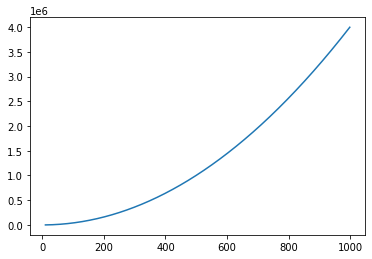

In [ ]:
plt.plot(range(10,1000),dest)

#### Basic Tests

In [ ]:
class TestLayerNormShapes():
    def __init__(self):
        self.hidden_size = 11
        self.layer_norm = LayerNorm(self.hidden_size)

    def test_forward_shape(self):
        shape = (3, 5, 7)
        inputs = torch.randn(*shape, self.hidden_size)

        outputs = self.layer_norm(inputs)

        expected_shape = (*shape, self.hidden_size)
        assert isinstance(outputs, torch.Tensor), (
            "The output of the module " "must be a torch.Tensor"
        )
        assert outputs.shape == expected_shape, (
            "The shape of the output of "
            "the module is invalid with `inputs` of shape {0}.\n  Got "
            "shape {1}\n  Expected shape: {2}\nRecall that the output should "
            "have shape (*dims, hidden_size)".format(
                tuple(inputs.shape), tuple(outputs.shape), expected_shape
            )
        )
if __name__ == "__main__":
    TestLayerNormShapes().test_forward_shape()

class TestMultiHeadAttentionShapes():
    def __init__(self):
        self.head_size = 11
        self.num_heads = 13
        self.sequence_length = 17

        self.attention = MultiHeadAttention(
            self.head_size, self.num_heads
        )

    def test_get_attention_weights_shape(self):
        batch_size = 7
        queries = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )
        keys = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )

        attention_weights = self.attention.get_attention_weights(queries, keys)

        expected_shape = (
            batch_size,
            self.num_heads,
            self.sequence_length,
            self.sequence_length,
        )
        assert isinstance(attention_weights, torch.Tensor), (
            "The output of " "`get_attention_weights` must be a torch.Tensor."
        )
        assert attention_weights.shape == expected_shape, (
            "The shape of your "
            "attention weights is invalid with `queries` of shape {0}, and "
            "`keys` of shape {1}.\n  Got shape: {2}\n  Expected shape: {3}\n"
            "Recall that the attention weights should have shape (batch_size, "
            "num_heads, sequence_length, sequence_length).".format(
                tuple(queries.shape),
                tuple(keys.shape),
                tuple(attention_weights.shape),
                expected_shape,
            )
        )

    def test_apply_attention_shape(self):
        batch_size = 7
        queries = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )
        keys = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )
        values = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )

        outputs = self.attention.apply_attention(queries, keys, values)

        expected_shape = (
            batch_size,
            self.sequence_length,
            self.num_heads * self.head_size,
        )
        assert isinstance(outputs, torch.Tensor), (
            "The output of " "`apply_attention` must be a torch.Tensor."
        )
        assert outputs.shape == expected_shape, (
            "The shape of the output of "
            "`apply_attention` is invalid with `queries` of shape {0}, `keys` "
            "of shape {1}, and `values` of shape {2}.\n  Got shape: {3}\n  "
            "Expected shape: {4}\nRecall that the attention weights should have "
            "shape (batch_size, sequence_length, num_heads * head_size).".format(
                tuple(queries.shape),
                tuple(keys.shape),
                tuple(values.shape),
                tuple(outputs.shape),
                expected_shape,
            )
        )

    def test_split_heads_shape(self):
        batch_size = 7
        dim = 23
        tensor = torch.randn(batch_size, self.sequence_length, self.num_heads * dim)

        output = self.attention.split_heads(tensor)

        expected_shape = (batch_size, self.num_heads, self.sequence_length, dim)
        assert isinstance(output, torch.Tensor), (
            "The output of `split_heads` " "must be a torch.Tensor."
        )
        assert output.shape == expected_shape, (
            "The shape of the output of "
            "`split_heads` is invalid with `tensor` of shape {0}.\n  Got shape "
            "{1}\n  Expected shape: {2}\nRecall that the output should have "
            "shape (batch_size, num_heads, sequence_length, dim)".format(
                tuple(tensor.shape), tuple(output.shape), expected_shape
            )
        )

    def test_merge_heads_shape(self):
        batch_size = 7
        dim = 23
        tensor = torch.randn(batch_size, self.num_heads, self.sequence_length, dim)

        output = self.attention.merge_heads(tensor)

        expected_shape = (batch_size, self.sequence_length, self.num_heads * dim)
        assert isinstance(output, torch.Tensor), (
            "The output of `merge_heads` " "must be a torch.Tensor."
        )
        assert output.shape == expected_shape, (
            "The shape of the output of "
            "`merge_heads` is invalid with `tensor` of shape {0}.\n  Got shape "
            "{1}\n  Expected shape: {2}\nRecall that the output should have "
            "shape (batch_size, sequence_length, num_heads * dim)".format(
                tuple(tensor.shape), tuple(output.shape), expected_shape
            )
        )

    def test_forward_shape(self):
        batch_size = 7
        hidden_states = torch.randn(
            batch_size, self.sequence_length, self.num_heads * self.head_size
        )

        outputs = self.attention(hidden_states, hidden_states, hidden_states)

        expected_shape = (
            batch_size,
            self.sequence_length,
            self.num_heads * self.head_size,
        )
        assert isinstance(outputs, torch.Tensor), (
            "The output of the module " "must be a torch.Tensor."
        )
        assert outputs.shape == expected_shape, (
            "The shape of the output of "
            "the module is invalid with `hidden_sizes` of shape {0}.\n  Got "
            "shape {1}\n  Expected shape: {2}\nRecall that the output should "
            "have shape (batch_size, sequence_length, num_heads * head_size)".format(
                tuple(hidden_states.shape), tuple(outputs.shape), expected_shape
            )
        )

if __name__ == "__main__":
    TestMultiHeadAttentionShapes().test_get_attention_weights_shape()
    TestMultiHeadAttentionShapes().test_apply_attention_shape()
    TestMultiHeadAttentionShapes().test_split_heads_shape()
    TestMultiHeadAttentionShapes().test_merge_heads_shape()
    TestMultiHeadAttentionShapes().test_forward_shape()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.keys()

dict_keys(['train_losses', 'train_ppls', 'train_times', 'valid_losses', 'valid_ppls', 'valid_times', 'test_loss', 'test_ppl', 'test_bleu1', 'test_bleu2', 'test_time'])

In [ ]:
def adding(l):
  sum = 0
  ll = []
  for a in l:
    sum = sum + a
    ll.append(sum)
  return ll

In [ ]:
f = open("/content/drive/MyDrive/transformer-adam-dropout_True-strategy_random.json","r")
data = json.load(f)


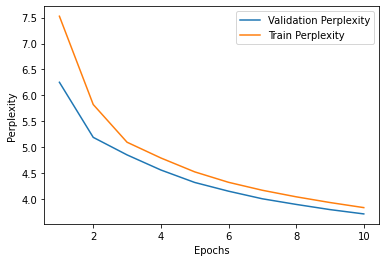

In [ ]:
#Over epochs
#the loss train validation
train_ppls = data['train_losses']
validation_ppls = data['valid_losses']
epochs = list(range(1,11))

plt.plot(epochs,validation_ppls)
plt.plot(epochs,train_ppls)
plt.legend(["Validation Perplexity","Train Perplexity"])

plt.xlabel("Epochs")
plt.ylabel("Perplexity")

plt.show()

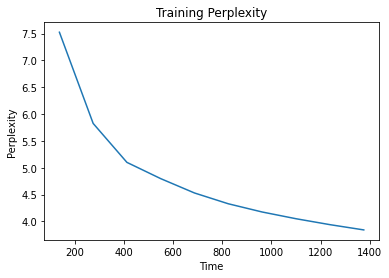

In [ ]:
#Over epochs
#the loss train validation
train_ppls = data['train_losses']
# validation_ppls = data['valid_ppls']
time_train = adding(data['train_times'])
time_valid = adding(data['valid_times'])

plt.plot(time_train,train_ppls)


plt.xlabel("Time")
plt.ylabel("Perplexity")
plt.title("Training Perplexity")
plt.show()

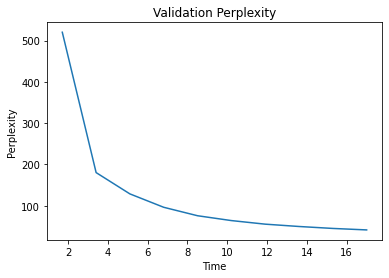

In [ ]:
train_ppls = data['train_ppls']
validation_ppls = data['valid_ppls']
time_train = adding(data['train_times'])
time_valid = adding(data['valid_times'])

plt.plot(time_valid,validation_ppls)


plt.xlabel("Time")
plt.ylabel("Perplexity")
plt.title("Validation Perplexity")
plt.show()

In [ ]:
print("train_losses",min(data["train_losses"]))
print("train_ppls",min(data["train_ppls"]))
print("valid_losses",min(data["valid_losses"]))
print("valid_ppld",min(data['valid_ppls']))
print("bleu1",data['test_bleu1'])
print("bleu2",data['test_bleu2'])

train_losses 3.8412273150708707
train_ppls 46.58261091080249
valid_losses 3.7200025618076324
valid_ppld 41.264499820185975
bleu1 22.00977901559599
bleu2 37.822267029453826
